In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import torch 
from torch.autograd import Variable 
from torch import optim
from itertools import combinations
import matplotlib.pyplot as plt

# Define the ```InsuranceCompany``` class

In [0]:
class InsuranceCompany: 

    def __init__(self): 
        self.param_ = dict()
        # Let the bid be uniformly in mean-span, mean+span
        self.param_['mean'] = 10 
        self.param_['span'] = 2
    
    def set_param(self, **kwargs):
        # Use this function to set parameters like married, num_of_vehicles etc 
        for k,v in kwargs.items(): 
            self.param_[k] = v 

    def get_param(self): 
        return self.param_

    def bid(self): 
        bid_mean = self.param_['mean']
        bid_span = self.param_['span']
        return (2*bid_span)*np.random.rand() + bid_mean - bid_span
        
        

## Function signature 

The sample use of this function is as follows. Note that parameters like ```num_of_drivers``` is used to distinguish between instances of the class, but do NOT affect the bedding behaviors. In practice, we only change the parameters like ```mean``` and ```span``` to train the models to fit to currently observed behaviors. 

In [0]:
# Initialize the insurance company object like this: 
ins = InsuranceCompany()
ins.set_param(num_of_driver=2)
print(ins.get_param())

{'mean': 10, 'span': 2, 'num_of_driver': 2}


In [0]:
# Ask the company to bid like this: 
ins.bid()

8.50293991225879

In [0]:
# Create our company who only bids $10
acme_company = InsuranceCompany()
acme_company.set_param(span=0)

In [0]:
# test that acme_company only bids $10 
acme_company.bid()

10.0

# Define the Environment class 

This is the class that simulates the bidding environment. Our company, together with four competing agents will each give a price, and the environment will compute the rank for our agent. Based on the rank, the environment returns a reward. 

$$Reward = \left\{ \begin{array}{ll} P-bid, & \text{if policy sold}  \\ -bid, & \text{if clicked but not sold} \\
0, & \text{if not clicked}\end{array} \right.$$

Each outcome's probability will be determined by the distribution of our given data. 

In [0]:
class BidEnvironment: 
    def __init__(self): 
        self.param_ = dict()
        # sale_prob_ = []
        # click_prob_ = []
        # P = 20.0 

    def set_param(self, **kwargs):
        ''' Use this function to set parameters
        '''
        for k,v in kwargs.items(): 
            self.param_[k] = v

    def rank_bid(self, bids): 
        ''' Computes the rank given bids 
        Args:
            bids (list): list of bids 
        Returns: 
            rank (list): rank of bids. rank[i] = ranking of i-th bid in bids 
        '''
        bids_sorted = sorted( [(bid,company) for company,bid in enumerate(bids)] , reverse=True)
        rank = [0]*5
        for r, pair in enumerate(bids_sorted):
            rank[pair[1]] = r 
        return rank 


    def gen_reward(self, bid, rank): 
        ''' Generates rewards and selling status according to rank
        Args:
            bid (float): our bid 
            rank (float): our rank 
        Returns:
            rewards (float): rewards 
            click (int): 1 iff clicked 
            sold (int): 1 iff sold 
        '''
        prob_clicking = self.param_['click_prob_'][rank]
        prob_selling = self.param_['sale_prob_'][rank]
        outcome = np.random.rand()
        if outcome < prob_selling: 
            # policy sold! 
            return (self.param_['P']-bid, 1,1)
        if outcome < prob_clicking: 
            # clicked but not sold 
            return (-bid, 1,0)
        # did not click 
        return (0,0,0)



We can initialize the environment like so: 

## Function signature

In [0]:
# Environment for, say no insurance, 1 driver, 1 vehicle, married
env = BidEnvironment()
# Infer unknown probability from the whole distribution 
env.set_param(click_prob_=[0.509, 0.215, 0.148, 0.038, 0.02], 
              sale_prob_=[0.2866, 0.1179, 0.06329, 0.031847, 0.009482], 
              P = 0) 

# Find distribution of competitors that fits our model

Notice that the combination of companies to make our sample distribution is certainly not unique. Here we fix the ```span``` parameters and tune the ```mean``` to fit to our model. There are 16 different combinations of customer categories, so we have to tune the model 16 times. 

In all models, we define the loss to be $L^2$ norm of the actual distribution and the ideal distribution: 

In [0]:
def mse(outcome, result): 
    '''
    Args: 
        outcome (pytorch Variable): some given distribution of ranking 
        result (pytorch Variable): desired distribution of ranking 
    Returns: 
        L^2 norm of error (pytorch Variable): ||outcome-result||_{L^2}^2
    '''
    # outcome = outcome predicted by model 
    # result = actual result 
    
    return torch.sum( torch.abs(outcome-result) )

def forward(x): 
    '''
    Args: 
        x (pytorch Variable): the input prob. x[i] = i-th competitor's probability of bidding more
            than $10 
    Returns:
        outcome (pytorch Variable): the resulting distribution of ranking. 
                                    outcome[i] = prob of [$10 rank=i+1]
    '''
    # Forward pass 
    outcome = torch.tensor([1.,1.,1.,1., 1.])
    outcome[0] = (1.-x[0])*(1.-x[1])*(1.-x[2])*(1.-x[3])
    outcome[1] = (1.-x[0])*(1.-x[1])*(1.-x[2])*(x[3]) \
                 + (1.-x[0])*(1.-x[1])*(x[2])*(1.-x[3]) \
                 + (1.-x[0])*(x[1])*(1.-x[2])*(1.-x[3]) \
                 + (x[0])*(1.-x[1])*(1.-x[2])*(1.-x[3])
    outcome[3] = x[0]*x[1]*x[2]*(1.0-x[3]) \
                 + x[0]*x[1]*(1.0-x[2])*x[3] \
                 + x[0]*(1.0-x[1])*x[2]*x[3] \
                 + (1.0-x[0])*x[1]*x[2]*x[3]
    outcome[4] = x[0]*x[1]*x[2]*x[3]
    outcome[2] = 1-outcome[0]-outcome[1]-outcome[3]-outcome[4]
    return outcome 

In [0]:
def forward_np(x): 
    # Forward pass 
    outcome = np.zeros(5)
    outcome[0] = (1.-x[0])*(1.-x[1])*(1.-x[2])*(1.-x[3])
    outcome[1] = (1.-x[0])*(1.-x[1])*(1.-x[2])*(x[3]) \
                 + (1.-x[0])*(1.-x[1])*(x[2])*(1.-x[3]) \
                 + (1.-x[0])*(x[1])*(1.-x[2])*(1.-x[3]) \
                 + (x[0])*(1.-x[1])*(1.-x[2])*(1.-x[3])
    outcome[3] = x[0]*x[1]*x[2]*(1.0-x[3]) \
                 + x[0]*x[1]*(1.0-x[2])*x[3] \
                 + x[0]*(1.0-x[1])*x[2]*x[3] \
                 + (1.0-x[0])*x[1]*x[2]*x[3]
    outcome[4] = x[0]*x[1]*x[2]*x[3]
    outcome[2] = 1-outcome[0]-outcome[1]-outcome[3]-outcome[4]
    return outcome 

We can automatically train the competitors to generate the desired distribution. 

In [0]:
def train(known_result, epochs=1000): 
    # Define conditions for model 
    desired_result = Variable(torch.tensor(known_result), requires_grad=False)
    prob = Variable(torch.rand(4), requires_grad=True)

    # model settings 
    learning_rate = 0.001
    # Set up optimizer 
    optim = torch.optim.SGD([prob], lr=learning_rate, momentum=.9)
    # Record log of training 
    loss_history = []

    for e in range(epochs): 
        optim.zero_grad()
        # print('Iteration', e)

        # Forward pass 
        outcome = forward(prob)

        # Compute loss 
        loss = mse(desired_result, outcome)

        # Record loss history 
        loss_history.append(loss.data)

        # Backward pass 
        loss.backward()
        optim.step()

        # Print loss 
        # print(' Training loss:', loss.data)
    
    return prob, loss_history

## Testing the algorithm on random initializations

In [0]:
prob = Variable(torch.tensor([1., 1., .8, .6, .35]), requires_grad=False)
dist = forward(prob)
print(prob.data)
print(dist.data)

tensor([1.0000, 1.0000, 0.8000, 0.6000, 0.3500])
tensor([0.0000, 0.0000, 0.0800, 0.4400, 0.4800])


In [0]:
output, _ = train(dist.data, 1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# print(output.data)
# print(prob.data)
print(forward(output).data)
print(dist.data)

tensor([-5.8302e-04, -9.8296e-05,  8.0923e-02,  4.4319e-01,  4.7657e-01])
tensor([0.0000, 0.0000, 0.0800, 0.4400, 0.4800])


In [0]:
# Record the training results
trained_prob = [None]*16

## Read data from EDA analysis

In [9]:
rank_distribution = pd.read_csv("/content/drive/My Drive/Colab Notebooks/rank_distribution.csv", index_col=0)
rank_distribution

,Rank1,Rank2,Rank3,Rank4,Rank5,TotalNum
0,0.179487,0.256410,0.256410,0.307692,0.000000,39
1,0.210456,0.261394,0.317694,0.210456,0.000000,746
2,0.495606,0.305800,0.198594,0.000000,0.000000,569
3,0.510673,0.264368,0.224959,0.000000,0.000000,609
4,0.000000,0.000000,0.189189,0.297297,0.513514,111
5,0.000000,0.000000,0.183805,0.314953,0.501242,2013
6,0.000000,0.200413,0.330579,0.266529,0.202479,484
7,0.000000,0.212815,0.297483,0.290618,0.199085,437
8,0.282051,0.205128,0.153846,0.358974,0.000000,39
9,0.209809,0.277929,0.305177,0.207084,0.000000,734


In [0]:
prob_click = pd.read_csv("/content/drive/My Drive/Colab Notebooks/prob_click.csv", index_col=0)
prob_sale = pd.read_csv("/content/drive/My Drive/Colab Notebooks/prob_sale.csv", index_col=0)

In [0]:
def type_to_index(ins, nv, nd, m): 
    return ins*8+(nv-1)*4 + (nd-1)*2 + m 

## Generate competitor strategy for all types of customers

In [0]:
loss_history = np.zeros((16,650))
trained_prob = [None]*16
for customer_type in range(16):
    print('Start training customer type {}'.format(customer_type))
    dist = rank_distribution.iloc[customer_type, :5].to_numpy()
    trained_prob[customer_type], loss_history[customer_type] = train(dist, 650)
    print('DONE with type {}'.format(customer_type))

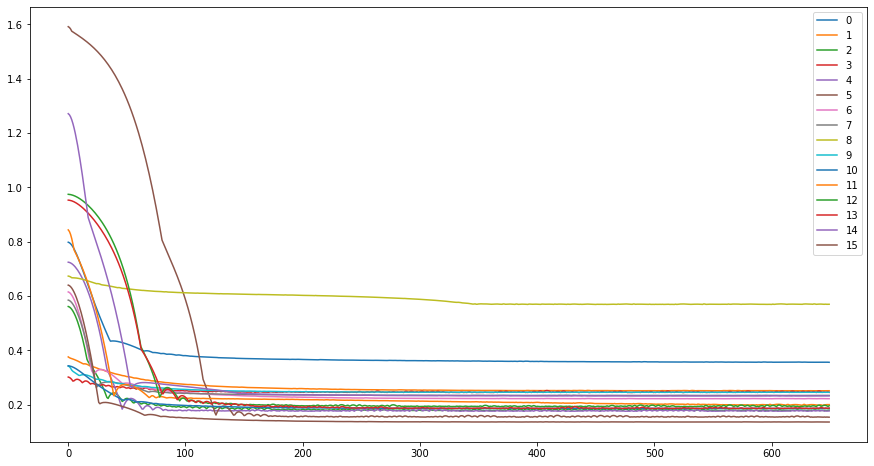

In [0]:
f = plt.figure(figsize=(15,8))
for i in range(16):
    plt.plot(loss_history[i], label=i)
plt.legend()
plt.show()

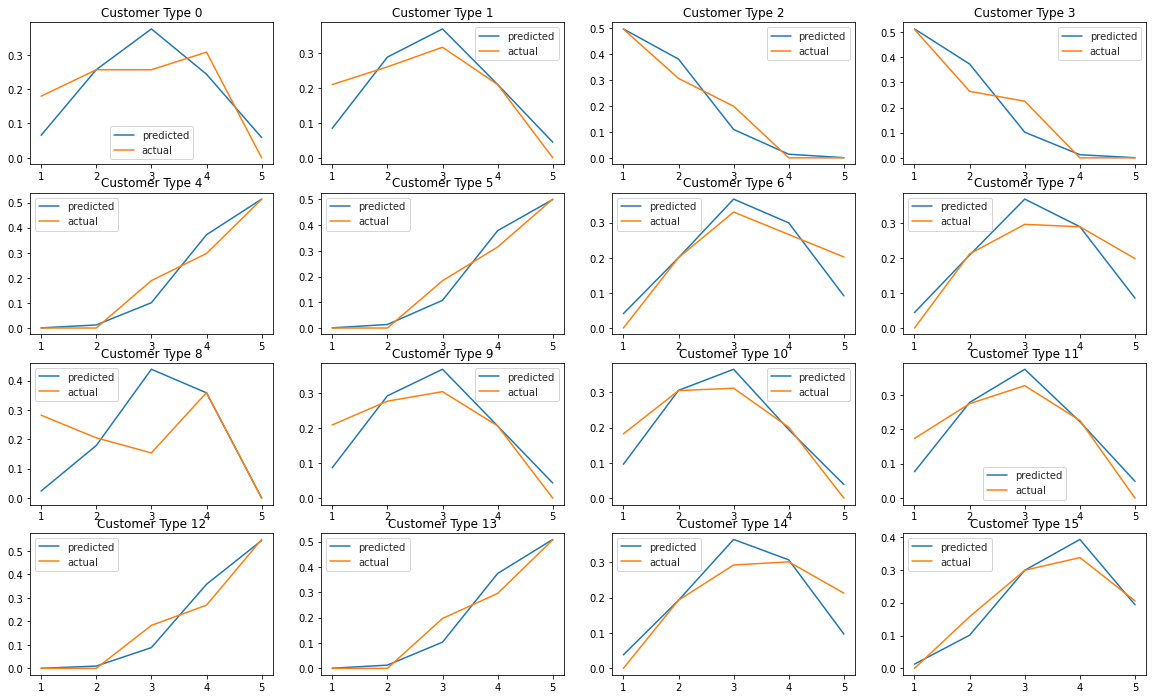

In [0]:
f, ax = plt.subplots(4,4, figsize=(20,12))
sns.set_style("whitegrid")
for ind in range(16):
    row_index = ind//4 
    col_index = ind%4
    plt.sca(ax[row_index, col_index])
    sns.lineplot([1,2,3,4,5], forward(trained_prob[ind]).data.numpy(), label="predicted")
    sns.lineplot([1,2,3,4,5], rank_distribution.iloc[ind, :5].to_numpy(), label="actual")
    ax[row_index, col_index].set_title("Customer Type "+str(ind))
    ax[row_index, col_index].legend()
plt.show()    

In [0]:
trained_prob_np = np.array([trained_prob[i].data.numpy() for i in range(16)])

In [0]:
pd.DataFrame(data=trained_prob_np).to_csv("/content/drive/My Drive/Colab Notebooks/trained_prob.csv")

## Load pre-trained company strategy

In [0]:
trained_prob_np = pd.read_csv("/content/drive/My Drive/Colab Notebooks/trained_prob.csv").to_numpy()

# Create competitors 


In [0]:
# Obtain competitor's probability of ranking higher than us 
trained_prob = pd.read_csv("/content/drive/My Drive/Colab Notebooks/trained_prob.csv", index_col=0)

Say their their distributions are uniform with ```span=1```. Then their probabilty of ranking higher than 10 will be $$\frac{(mean+span)-10}{2\cdot span} = p,$$ which means that $$
mean = 10+2p\cdot span - span.
$$

Therefore, when our new bid is $b$, the probability that the company will bid higher than us is: 
$$\frac{mean+span-b}{2\cdot span} = \frac{10+2p\cdot span-b}{2\cdot span} = p+\frac{10-b}{2\cdot span}.$$
Of course, if the answer is beyond $[0,1]$ we round the answers to $0$ and $1$ respectively. 

In [0]:
# def round_prob(p):
#     if p > 1: 
#         return 1 
#     if p < 0:
#         return 0 
#     return p 

In [0]:
competitor_means = np.zeros((16,4))
competitor_spans = 2.

for customer_type in range(16):
    # p_click = prob_click.iloc[customer_type]
    # p_sale = prob_sale.iloc[customer_type]
    competitor_means[customer_type] = 2*competitor_spans\
                                        *trained_prob[customer_type].data.numpy() \
                        + 10 - competitor_spans

In [0]:
competitor_means

array([[ 9.39952374,  9.39853954,  9.39883995,  9.39776897],
       [ 9.83795738,  9.83981419,  9.84245968,  9.83233166],
       [ 8.64503384,  8.64496422,  8.64477634,  8.64060116],
       [ 8.61957741,  8.61985779,  8.61870289,  8.61983585],
       [11.39404583, 11.39375305, 11.39311409, 11.39311123],
       [11.36923599, 11.36856651, 11.36762333, 11.36764812],
       [10.19166183, 10.19344807, 10.23614788, 10.19214153],
       [10.15671062, 10.16742134, 10.16085911, 10.16301632],
       [ 9.08669376,  9.08931732,  9.08790779,  9.08641529],
       [ 9.37281609,  9.37506676,  9.37430573,  9.37507153],
       [ 9.78830624,  9.78721905,  9.78798485,  9.73179245],
       [ 9.88661861,  9.90587711,  9.90522957,  9.89149952],
       [11.43933582, 11.43832016, 11.43806934, 11.43806934],
       [11.37781906, 11.38134193, 11.3778286 , 11.37796783],
       [10.23112583, 10.23335934, 10.23361015, 10.23863888],
       [10.65595436, 10.65444946, 10.65487385, 10.65442848]])

# Optimization

## Load data

In [0]:
# Read pre-trained competitor strategy
trained_prob = pd.read_csv("/content/drive/My Drive/Colab Notebooks/trained_prob.csv", index_col=0)
trained_prob_np = trained_prob.to_numpy()
trained_prob_tensor = Variable(torch.tensor(trained_prob_np), requires_grad=False)

## Define functions

In [0]:
def prob_bid_higher(b): 
    """ Compute competitor's probability of bidding higher than us 
    Args: 
        b: shape (16,1)
    Returns:
        prob_bid_higher: shape (16, 4)
    """
    prob = torch.zeros(16,4)
    prob = trained_prob_tensor + .25*(10.0 - b)
    prob = torch.min(prob, torch.ones_like(prob))
    prob = torch.max(prob, torch.zeros_like(prob))
    return prob 


In [0]:
# # test prob_bid_higher 
# b = Variable(10*torch.ones(16,1))
# output = prob_bid_higher(b)
# print(output)

In [0]:
def rank_one_bid(x): 
    '''
    Args: 
        x (pytorch Variable): the input prob. x[i] = i-th competitor's probability of bidding more
            than our bid 
    Returns:
        outcome (pytorch Variable): the resulting distribution of ranking. 
                                    outcome[i] = prob of [$10 rank=i+1]
    '''
    # Forward pass 
    outcome = torch.zeros(5,1)
    outcome[0] = (1.-x[0])*(1.-x[1])*(1.-x[2])*(1.-x[3])
    outcome[1] = (1.-x[0])*(1.-x[1])*(1.-x[2])*(x[3]) \
                 + (1.-x[0])*(1.-x[1])*(x[2])*(1.-x[3]) \
                 + (1.-x[0])*(x[1])*(1.-x[2])*(1.-x[3]) \
                 + (x[0])*(1.-x[1])*(1.-x[2])*(1.-x[3])
    outcome[3] = x[0]*x[1]*x[2]*(1.0-x[3]) \
                 + x[0]*x[1]*(1.0-x[2])*x[3] \
                 + x[0]*(1.0-x[1])*x[2]*x[3] \
                 + (1.0-x[0])*x[1]*x[2]*x[3]
    outcome[4] = x[0]*x[1]*x[2]*x[3]
    outcome[2] = 1-outcome[0]-outcome[1]-outcome[3]-outcome[4]
    return outcome 

In [0]:
def rank_matrix(b): 
    """Compute distribution of ranks given bids 
    Args: 
        b (pytorch Variable): shape (16,1)
    Returns:
        rank (pytorch Variable): shape(16, 5)
    """
    rank = torch.zeros(16,5)
    for i in range(16): 
        rank[i] = rank_one_bid(prob_bid_higher(b)[i,:]).view(1,-1)
    
    return rank 

In [0]:
# # test rank_matrix
# output = rank_matrix(b)
# print(output)

In [0]:
PROB_CLICK = Variable(torch.tensor(prob_click.to_numpy()).type(torch.FloatTensor), requires_grad=False)
PROB_SALE = Variable(torch.tensor(prob_sale.to_numpy()).type(torch.FloatTensor), requires_grad=False)

In [0]:
def conditional_prob_click(b): 
    ans = torch.zeros(16)
    for i in range(16):
        ans[i] = torch.dot(rank_matrix(b)[i], PROB_CLICK[i])
    return ans 

def conditional_prob_sale(b): 
    ans = torch.zeros(16)
    for i in range(16):
        ans[i] = torch.dot(rank_matrix(b)[i], PROB_SALE[i])
    return ans 

In [0]:
# # print(b.type(), rank_matrix(b).type(), PROB_SALE.type())
# conditional_prob_sale(b)

tensor([0.1281, 0.0889, 0.1852, 0.1442, 0.0173, 0.0216, 0.0430, 0.0416, 0.2114,
        0.0842, 0.0415, 0.0389, 0.0112, 0.0157, 0.0313, 0.0221])

In [0]:
CUSTOMER_DISTRIBUTION = Variable(torch.tensor(rank_distribution['TotalNum'].to_numpy()/10000).type(torch.FloatTensor), requires_grad=False).view(16,1)

In [0]:
def cost_per_customer(b): 
    c = conditional_prob_click(b).view(16,1)
    s = conditional_prob_sale(b).view(16,1)

    # expected_costs = torch.zeros(16)
    # expected_sales = torch.zeros(16)
    # print(c.type(), s.type(), b.type(), CUSTOMER_DISTRIBUTION.type())
    expected_costs = (CUSTOMER_DISTRIBUTION*c*torch.max(torch.zeros_like(b),b)).sum()
    expected_sales = (CUSTOMER_DISTRIBUTION*s).sum()
    return torch.div(expected_costs, expected_sales)


In [0]:
def train_bids(lr, epochs=200): 
    # Define conditions for model 
    bids = Variable(19.*torch.rand(16,1), requires_grad=True)

    # model settings 
    optim = torch.optim.SGD([bids], lr=lr, momentum=.9) 

    # Record log of training 
    loss_history = [None]*epochs
    percent_sold_history = [None]*epochs
    # bids_history = [None]*epochs

    for e in range(epochs): 
        optim.zero_grad()
        
        print('Iteration', e)

        # Forward pass 
        loss = cost_per_customer(bids)

        # Record loss history 
        loss_history[e] = loss.data

        # Backward pass 
        loss.backward()
        optim.step()

        # Print loss 
        print(' Training loss:', loss.data)

        # Record history 
        bids_static = Variable(bids.data, requires_grad=False)
        c = conditional_prob_click(bids_static)
        s = conditional_prob_sale(bids_static)
        percent_sold_history[e] = (s * CUSTOMER_DISTRIBUTION.view(16)).sum().item()
        # bids_history[e] = bids.data.numpy().reshape(-1)
        if percent_sold_history[e]<0.04: break 
        if (any(bids.data.numpy()<0)): break

        if loss_history[e] > 25: 
            continue 
        elif loss_history[e] > 22: 
            optim = torch.optim.SGD([bids], lr=.1, momentum=.9) 
        elif loss_history[e] > 20: 
            optim = torch.optim.SGD([bids], lr=.08, momentum=.9) 
        else: 
            optim = torch.optim.SGD([bids], lr=.05, momentum=.9) 
        




    
    return bids, loss_history, percent_sold_history

In [0]:
def continue_train_bids(bids, loss_history, percent_sold_history, 
                        lr, e_done, epochs=100): 
    # model settings 
    optim = torch.optim.SGD([bids], lr=lr, momentum=.9) 

    # Record log of training 
    loss_history = loss_history + [None]*epochs
    percent_sold_history = percent_sold_history+[None]*epochs
    # bids_history = bids_history+[None]*epochs

    for e in range(epochs): 
        e = e+e_done
        optim.zero_grad()
        print('Iteration', e)

        # Forward pass 
        loss = cost_per_customer(bids)

        # Record loss history 
        loss_history[e] = loss.data

        # Backward pass 
        loss.backward()
        optim.step()

        # Record history 
        bids_static = Variable(bids.data, requires_grad=False)
        c = conditional_prob_click(bids_static)
        s = conditional_prob_sale(bids_static)
        percent_sold_history[e] = (s * CUSTOMER_DISTRIBUTION.view(16)).sum().item()
        # bids_history[e] = bids.data.numpy().reshape(-1)

        if percent_sold_history[e]<0.04: break 
        if (any(bids.data.numpy()<0)): break

        if loss_history[e] > 25: 
            continue 
        elif loss_history[e] > 22: 
            optim = torch.optim.SGD([bids], lr=.1, momentum=.9) 
        elif loss_history[e] > 20: 
            optim = torch.optim.SGD([bids], lr=.08, momentum=.9) 
        else: 
            optim = torch.optim.SGD([bids], lr=.05, momentum=.9) 
        



        # Print loss 
        print(' Training loss:', loss.data)
    
    return bids, loss_history, percent_sold_history

## Training

In [96]:
bids, loss_history, percent_sold_history = train_bids(.1, 250)
# bids, loss_history, percent_sold_history = \
#     continue_train_bids(bids, loss_history, percent_sold_history, 
#                         .1, 200, 100)


Iteration 0
 Training loss: tensor(33.4727)
Iteration 1
 Training loss: tensor(33.3870)
Iteration 2
 Training loss: tensor(33.2244)
Iteration 3
 Training loss: tensor(32.9927)
Iteration 4
 Training loss: tensor(32.6426)
Iteration 5
 Training loss: tensor(32.1762)
Iteration 6
 Training loss: tensor(31.6638)
Iteration 7
 Training loss: tensor(31.1317)
Iteration 8
 Training loss: tensor(30.5882)
Iteration 9
 Training loss: tensor(30.0312)
Iteration 10
 Training loss: tensor(29.6123)
Iteration 11
 Training loss: tensor(29.1528)
Iteration 12
 Training loss: tensor(28.6283)
Iteration 13
 Training loss: tensor(28.0592)
Iteration 14
 Training loss: tensor(27.4580)
Iteration 15
 Training loss: tensor(26.8332)
Iteration 16
 Training loss: tensor(26.1911)
Iteration 17
 Training loss: tensor(25.5364)
Iteration 18
 Training loss: tensor(24.9367)
Iteration 19
 Training loss: tensor(24.8037)
Iteration 20
 Training loss: tensor(24.7394)
Iteration 21
 Training loss: tensor(24.6779)
Iteration 22
 Traini

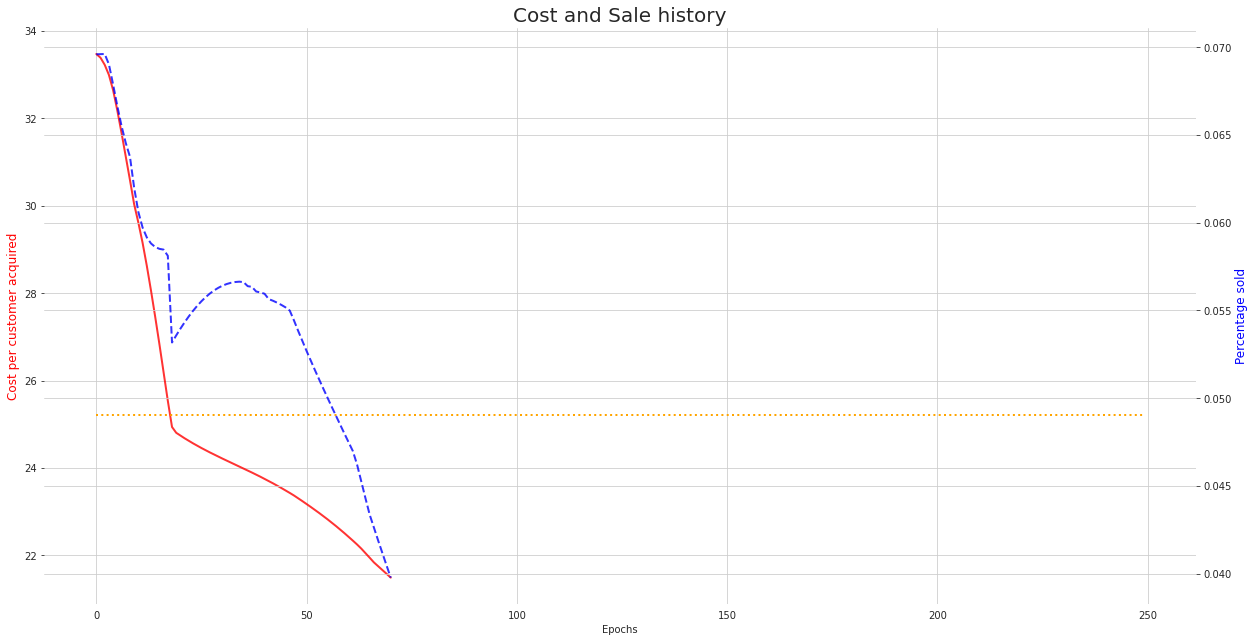

In [97]:
fig = plt.figure(figsize=(16,8))
TOTAL_EPOCHS = 250
line_weight = 2
alpha = .8
sns.set_style("whitegrid")
plt.rcParams['axes.linewidth'] = 0

ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes()
ax2 = ax1.twinx()



lns1 = ax1.plot(range(TOTAL_EPOCHS), loss_history, color='red', lw=line_weight, alpha=alpha, 
                label='Cost per customer acquired')
ax1.set_ylabel('Cost per customer acquired', color='red', 
               fontsize=12)
# plt.text(70,1,"Current cost per customer acquired = $25.21", c='orange', 
#          fontsize=15)
ax1.spines['left'].set_color('red')

lns2 = ax2.plot(range(TOTAL_EPOCHS), percent_sold_history, color='blue', lw=line_weight, alpha=alpha, 
                linestyle='--', 
                label='Percentage sold')
ax1.plot(range(TOTAL_EPOCHS), 25.21*np.ones(TOTAL_EPOCHS), linestyle=':', color='orange', lw=line_weight)
ax2.set_ylabel('Percentage sold', color='blue', 
               fontsize=12)
ax1.spines['right'].set_color('blue')

# # Solution for having two legends
# leg = lns1 + lns2
# labs = [l.get_label() for l in leg]
# ax1.legend(leg, labs, loc=0)



ax1.set_xlabel('Epochs')
plt.title('Cost and Sale history', fontsize=20)
plt.show()

In [98]:
bids_static = bids.data.numpy()
bids_static
# pd.DataFrame(data=bids_static).to_csv('/content/drive/My Drive/Colab Notebooks/bids_static.csv')

array([[11.154937  ],
       [11.453321  ],
       [ 5.8987646 ],
       [ 1.7284117 ],
       [ 0.70889527],
       [ 1.2786103 ],
       [ 3.4304385 ],
       [11.721222  ],
       [ 8.455078  ],
       [ 4.4105234 ],
       [ 7.182082  ],
       [ 0.9595611 ],
       [12.643197  ],
       [ 7.244098  ],
       [11.316329  ],
       [10.028174  ]], dtype=float32)

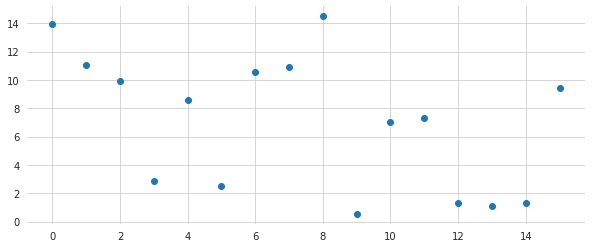

In [69]:
f = plt.figure(figsize=(10,4))
bids_static = bids.data.numpy().reshape(16,1)
plt.scatter(range(16), bids_static)
plt.show()

In [0]:
customer_types = []
for ins in [0,1]:
    for nv in [1,2]:
        for nd in [1,2]:
            for ma in [0,1]:
                    customer_types.append([ins,nv,nd,ma])
customer_types = np.array(customer_types)

In [0]:
bids_strategy = pd.DataFrame(data=np.concatenate([customer_types, bids_static], axis=1), 
             columns=['insured', 'n_vehicle', 'n_driver', 'married', 'bid'])\
             .astype({'insured':int, 'n_vehicle':int, 'n_driver':int, 'married':int})

In [0]:
summary = pd.concat([bids_strategy, prob_sale/prob_click, rank_distribution['TotalNum']], axis=1).sort_values(by='bid', ascending=False)

In [101]:
summary

,insured,n_vehicle,n_driver,married,bid,0,1,2,3,4,TotalNum
12,1,2,1,0,12.643197,0.495250,0.432851,0.400000,0.000000,NaN,93
7,0,2,2,1,11.721222,0.480911,0.388889,0.312500,0.000000,0.000000,437
1,0,1,1,1,11.453321,0.562500,0.547619,0.428571,0.833333,0.173049,746
14,1,2,2,0,11.316329,0.446731,0.250000,0.210526,0.400000,0.000000,451
0,0,1,1,0,11.154937,0.500000,1.000000,0.000000,NaN,0.264790,39
15,1,2,2,1,10.028174,0.388226,0.125000,0.181818,0.400000,0.333333,438
8,1,1,1,0,8.455078,0.571429,1.000000,NaN,1.000000,0.202138,39
13,1,2,1,1,7.244098,0.524238,0.726805,0.196970,0.357143,0.529412,2056
10,1,1,2,0,7.182082,0.285714,0.264706,0.200000,0.166667,0.261853,587
2,0,1,2,0,5.898765,0.524138,0.527778,0.454545,0.584948,0.441442,569


In [0]:
import plotly.express as px

In [102]:
fig = px.scatter(summary, x="0", y="bid",
	         size="TotalNum",
            size_max=60, color='1')
fig.update_xaxes(title_text='Prob of sale conditional on click if rank=1')
fig.update_yaxes(title_text='Proposed bid')
fig.update_layout(coloraxis_colorbar=dict(
    title="Prob of sale/click if rank=2"
))
fig.show()

# Old codes...

In [0]:
def make_competitors(probs, span=2): 
    """ Make competitors 
    probs: probability that each competitor bids > $10
    """
    competitors = [None]*4
    # probs = trained_prob['no,1d,1v,m'].data.numpy()
    # span=2
    for i in range(4): 
        competitors[i] = InsuranceCompany()
        competitors[i].set_param(span=span, 
                                mean=10+2*probs[i]*span-span)
        print('Set up competitor {}, span={}, mean={}'.format(\
                i, competitors[i].param_['span'], competitors[i].param_['mean']))
    return competitors

In [0]:
# Simulate bidding 
def simulate(our_bid, competitors, env, num_trials=2000): 
    # Set up parameters 
    total_rewards = 0 
    total_sold = 0 
    rank_history = [0]*5 
    
    # Simulate each trial 
    for t in range(num_trials):
        # Let all competitors bid 
        bids = [c.bid() for c in competitors]
        our_rank = env.rank_bid([our_bid]+bids)[0]
        this_reward, clicked, sold = env.gen_reward(our_bid, our_rank)
        if sold: 
            total_sold += 1
        total_rewards += this_reward
        rank_history[our_rank] += 1
    return total_rewards, total_sold, rank_history

In [0]:
def cost_curve(category, bid_list, competitors, env, num_of_customers_in_category=2000):
    # competitors = make_competitors(trained_prob[category].data.numpy())
    # bid_list = np.linspace(8,14,35)
    cost_per_customer_history = np.zeros_like(bid_list, float)
    percentage_sold_history = np.zeros_like(bid_list, float)
    # num_of_customers_in_category = 10000
    for i,our_bid in enumerate(bid_list):
        # print("Simulating bid price {}".format(out_bid))
        total_rewards, total_sold, _ = simulate(our_bid, competitors, env, num_of_customers_in_category)
        cost_per_customer_history[i] = -np.divide(total_rewards, total_sold)
        percentage_sold_history[i] = np.divide(total_sold, num_of_customers_in_category)
    return cost_per_customer_history, percentage_sold_history

Next, we perform a grid search to determine to optimal bid price to have lowest cost per costomer acquired. 

In [0]:
bid_list = np.linspace(7.5,11.5,10)
cost_per_customer_history = np.zeros((16, bid_list.size))
percentage_sold_history = np.zeros((16, bid_list.size))

Simulating customer type 0
Set up competitor 0, span=2, mean=9.399523735046387
Set up competitor 1, span=2, mean=9.398539543151855
Set up competitor 2, span=2, mean=9.398839950561523
Set up competitor 3, span=2, mean=9.3977689743042
Simulating customer type 1
Set up competitor 0, span=2, mean=9.837957382202148
Set up competitor 1, span=2, mean=9.839814186096191
Set up competitor 2, span=2, mean=9.842459678649902
Set up competitor 3, span=2, mean=9.832331657409668
Simulating customer type 2
Set up competitor 0, span=2, mean=8.645033836364746
Set up competitor 1, span=2, mean=8.644964218139648
Set up competitor 2, span=2, mean=8.644776344299316
Set up competitor 3, span=2, mean=8.64060115814209
Simulating customer type 3
Set up competitor 0, span=2, mean=8.619577407836914
Set up competitor 1, span=2, mean=8.619857788085938
Set up competitor 2, span=2, mean=8.61870288848877
Set up competitor 3, span=2, mean=8.61983585357666
Simulating customer type 4
Set up competitor 0, span=2, mean=11.3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Simulating customer type 5
Set up competitor 0, span=2, mean=11.36923599243164
Set up competitor 1, span=2, mean=11.368566513061523
Set up competitor 2, span=2, mean=11.367623329162598
Set up competitor 3, span=2, mean=11.367648124694824
Simulating customer type 6
Set up competitor 0, span=2, mean=10.191661834716797
Set up competitor 1, span=2, mean=10.193448066711426
Set up competitor 2, span=2, mean=10.2361478805542
Set up competitor 3, span=2, mean=10.19214153289795
Simulating customer type 7
Set up competitor 0, span=2, mean=10.156710624694824
Set up competitor 1, span=2, mean=10.167421340942383
Set up competitor 2, span=2, mean=10.160859107971191
Set up competitor 3, span=2, mean=10.163016319274902
Simulating customer type 8
Set up competitor 0, span=2, mean=9.08669376373291
Set up competitor 1, span=2, mean=9.089317321777344
Set up competitor 2, span=2, mean=9.087907791137695
Set up competitor 3, span=2, mean=9.08641529083252
Simulating customer type 9
Set up competitor 0, span=2

ZeroDivisionError: ignored

In [0]:
for customer_type in range(12,16):
    print("Simulating customer type "+str(customer_type))
    # Set environment's parameters
    env.set_param(P=0, 
                click_prob_=prob_click.iloc[customer_type].to_numpy(), 
                sale_prob_=prob_sale.iloc[customer_type].to_numpy())
    # Create competitors 
    competitors = make_competitors(trained_prob[customer_type])

    # Simulate
    cost_per_customer_history[customer_type], percentage_sold_history[customer_type] = cost_curve(customer_type, bid_list, competitors, env)

Simulating customer type 12
Set up competitor 0, span=2, mean=11.439335823059082
Set up competitor 1, span=2, mean=11.43832015991211
Set up competitor 2, span=2, mean=11.438069343566895
Set up competitor 3, span=2, mean=11.438069343566895


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Simulating customer type 13
Set up competitor 0, span=2, mean=11.377819061279297
Set up competitor 1, span=2, mean=11.381341934204102
Set up competitor 2, span=2, mean=11.377828598022461
Set up competitor 3, span=2, mean=11.377967834472656
Simulating customer type 14
Set up competitor 0, span=2, mean=10.231125831604004
Set up competitor 1, span=2, mean=10.233359336853027
Set up competitor 2, span=2, mean=10.233610153198242
Set up competitor 3, span=2, mean=10.238638877868652


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Simulating customer type 15
Set up competitor 0, span=2, mean=10.655954360961914
Set up competitor 1, span=2, mean=10.654449462890625
Set up competitor 2, span=2, mean=10.654873847961426
Set up competitor 3, span=2, mean=10.654428482055664


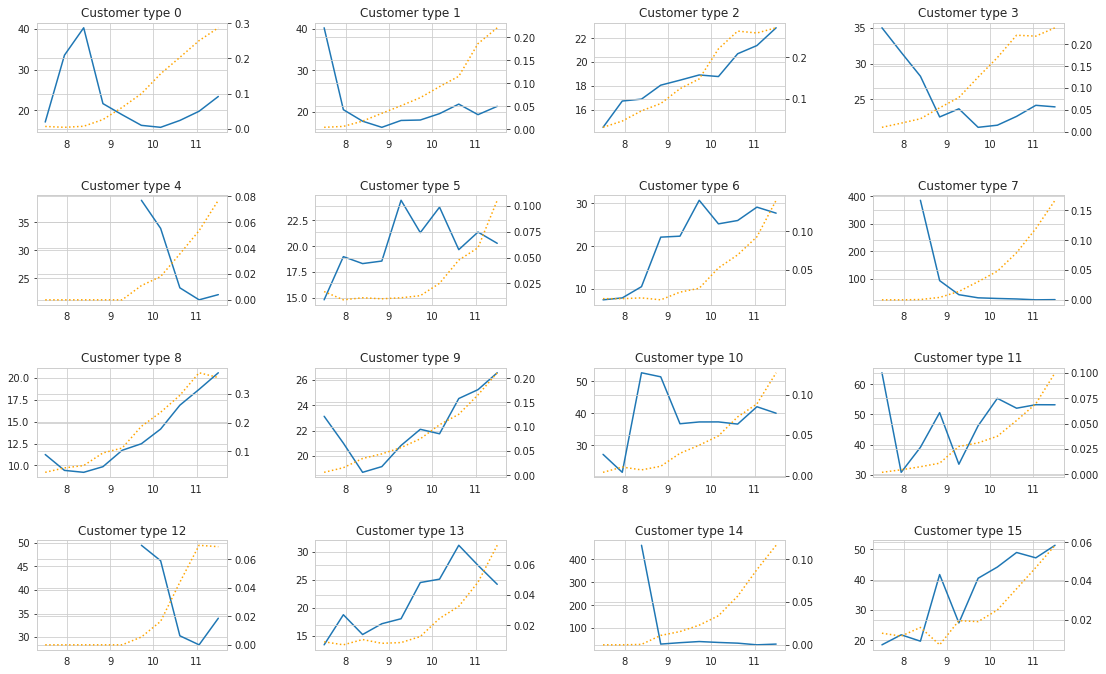

In [0]:
f, axs = plt.subplots(4,4,figsize=(16,10))
for c in range(16):
    row_index = c//4 
    col_index = c%4 
    ax1 = axs[row_index, col_index]
    # ax1.set_xlabel('time (s)')
    # ax1.set_ylabel('exp', color=color)
    ax1.plot(bid_list, cost_per_customer_history[c], label='cost per customer')
    ax2 = ax1.twinx()
    ax2.plot(bid_list, percentage_sold_history[c], 
             linestyle=':', 
             color='orange', 
             label='Percentage sold')
    ax1.set_title('Customer type '+str(c))
    # ax1.legend()
    # ax2.legend()


# ax1.plot(t, data1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# # ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'tab:blue'
# ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
# ax2.plot(t, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)


#     ax[row_index, col_index] = 
# ax[0].plot(bid_list, cost_per_customer_history)
# ax[0].set_title('Cost per customer acquired')
# ax[1].plot(bid_list, percentage_sold_history)
# ax[1].set_title('Percentage sold')
f.tight_layout(pad=3.0)
